In [3]:
import os
import h5py
import pandas as pd
from tqdm import tqdm_notebook
import sys
import warnings
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')

In [5]:
#dataset_type = 'train'
dataset_type = 'dev'
dataset_version = 'v1.1'

index_field = ['Unnamed: 0']

# required files
_basepath = '/home/jackalhan/Development/github/bilm-tf/squad'
datadir = os.path.join(_basepath, dataset_type)
modeldir = os.path.join(_basepath, 'model')

_qas_file_name = '{}_qas.csv'.format(dataset_type)
qas_file = os.path.join(datadir, _qas_file_name)

_embedding_mean_paragraph_file_as_h5py_name = 'elmo_mean_paragraph_embeddings.hdf5'
embedding_mean_paragraph_file_as_h5py = os.path.join(datadir, _embedding_mean_paragraph_file_as_h5py_name)

_embedding_mean_question_file_as_h5py_name = 'elmo_mean_question_embeddings.hdf5'
embedding_mean_question_file_as_h5py = os.path.join(datadir, _embedding_mean_question_file_as_h5py_name)

_cos_similarity_results_file_name =  '{}_cos_similarity_q_vs_para.csv'.format(dataset_type)
cos_similarity_results_file_name = os.path.join(datadir, _cos_similarity_results_file_name)

df_qas = pd.read_csv(qas_file).set_index(index_field)

In [6]:
dims = 1024
items = [dict({'type':'question', 
                     'matrix': np.empty((0, dims), dtype=float), 
                     'source_file':embedding_mean_question_file_as_h5py
                     }), 
              dict({'type':'paragraph', 
                     'matrix':np.empty((0, dims), dtype=float), 
                     'source_file':embedding_mean_paragraph_file_as_h5py,
                     })
              ]

for vals in items:
    print(vals['type'], 'is getting processed!!!')
    with h5py.File(vals['source_file'], 'r') as fin:        
        for _ in tqdm_notebook(fin, total=len(fin)):             
            vec = np.reshape(np.array(fin[str(_)][...]), (1,dims))                                   
            vals['matrix'] = np.append(vals['matrix'], vec, axis=0)

question is getting processed!!!


HBox(children=(IntProgress(value=0, max=10570), HTML(value='')))


paragraph is getting processed!!!


HBox(children=(IntProgress(value=0, max=2067), HTML(value='')))

In [7]:
QUES = items[0]['matrix']
print('QUES', QUES.shape)
PARA = items[1]['matrix']
print('PARA', PARA.shape)

QUES (10570, 1024)
PARA (2067, 1024)


In [8]:
results = []
for q_id, _ in enumerate(tqdm_notebook(QUES, total=len(QUES))):
    q_vec = np.array([_]) 
    sk_sim = cosine_similarity(q_vec,PARA)[0]
    actual_paragraph_id = df_qas[df_qas['Question_Id'] == q_id]['Paragraph_Id'].values[0]
    similarities = np.argsort(-sk_sim)
    order_of_the_actual_paragraph_id = np.where(similarities == actual_paragraph_id)[0][0] + 1
    calculated_most_similar_1_paragraph = similarities[0]
    results.append((q_id, actual_paragraph_id,  order_of_the_actual_paragraph_id, calculated_most_similar_1_paragraph, sk_sim[calculated_most_similar_1_paragraph]))


HBox(children=(IntProgress(value=0, max=10570), HTML(value='')))

In [9]:
df_results= pd.DataFrame(data=results, columns=['Question_Id', 'Actual_Paragraph_Id', 
                                                 'Order Index of Actual_Paragraph_Id in Similarities List',
                                                 'Calculated Top 1 Most Similar Paragraph', 
                                                 'Similarity Score for Most Similar Paragraph'
                                                ])
df_results.to_csv(cos_similarity_results_file_name, index=False)

In [10]:
df_results = pd.read_csv(cos_similarity_results_file_name).set_index('Question_Id')

In [11]:
x = df_results['Order Index of Actual_Paragraph_Id in Similarities List']

(array([4., 2., 2., ..., 6., 2., 8.]),
 array([   1,    2,    3, ..., 2065, 2066, 2067]),
 <a list of 2066 Patch objects>)

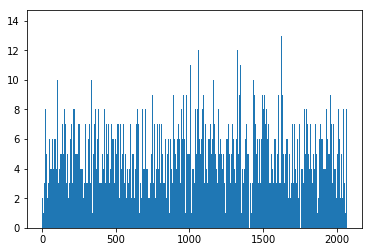

In [12]:
plt.hist(x, bins=range(min(x), max(x) + 1, 1))